# Frequency Demo

This is a notebook to demonsrate how to visualize the results of BackdoorBench by
* Frequency domain

## Step 0: Generate Results File (optional)

In this notebook, we visualization the result of Badnet Attack on CIFAR10 with PreactResnet18 and poison ratio 10%. 
We assume that the results are stored in **'../record/cifar10_preactresnet18_badnet_0_1'** which can be generated using the following command.

In [ ]:
! python -u ../attack/badnets_attack.py --yaml_path ../config/attack/badnet/cifar10.yaml  --model preactresnet18 --pratio  0.1 --save_folder_name cifar10_preactresnet18_badnet_0_1   --dataset cifar10

## Step 1: Load results

In [2]:
import sys, os
import yaml
import torch
import numpy as np
import torch.nn as nn
import torchvision.transforms as transforms
import random
import matplotlib as mlp
sys.path.append("../")
sys.path.append(os.getcwd())
from visual_utils import *
from utils.aggregate_block.dataset_and_transform_generate import (
    get_transform,
    get_dataset_denormalization,
)
from utils.aggregate_block.model_trainer_generate import generate_cls_model
from utils.bd_dataset import prepro_cls_DatasetBD
from utils.save_load_attack import load_attack_result

### 1. basic setting: args
def get_args():
    #set the basic parameter
    parser = argparse.ArgumentParser()
    
    parser.add_argument('--device', type=str, help='cuda, cpu')
    parser.add_argument('--yaml_path', type=str, default="../config/visualization/cifar10.yaml", help='the path of yaml')
    parser.add_argument('--seed', type=str, help='random seed')
    parser.add_argument('--model', type=str, help='preactresnet18')

    # data parameters
    parser.add_argument("--dataset_path", type=str)
    parser.add_argument('--dataset', type=str, help='mnist, cifar10, cifar100, gtsrb, celeba, tiny') 
    parser.add_argument("--num_classes", type=int)
    parser.add_argument("--input_height", type=int)
    parser.add_argument("--input_width", type=int)
    parser.add_argument("--input_channel", type=int)
    parser.add_argument('--batch_size', type=int)
    parser.add_argument('--n_sub', default = 5000, type=int)
    parser.add_argument('--c_sub', default = 10, type=int)
    parser.add_argument("--num_workers", default=2, type=float)
    parser.add_argument('--class_names', type=list, help='names for each class') 

    # BD parameters
    parser.add_argument('--pratio', type=float)
    parser.add_argument('--attack_target', type=int)
    parser.add_argument('--index', type=str, help='index of clean data')

    # results parameters
    parser.add_argument('--result_file_attack', type=str, help='the location of attack result')
    parser.add_argument('--result_file_defense', type=str, help='the location of defense result')
    parser.add_argument('--checkpoint_load', type=str)
    parser.add_argument('--checkpoint_save', type=str)

    arg = parser.parse_args([])
    return arg

args = get_args()
with open(args.yaml_path, "r") as stream:
    config = yaml.safe_load(stream)
config.update({k: v for k, v in args.__dict__.items() if v is not None})
args.__dict__ = config
args.result_file_attack = "cifar10_preactresnet18_badnet_0_1"
args.result_file_defense = "None"
args.dataset = "cifar10"
args = preprocess_args(args)

save_path_attack = "../record/" + args.result_file_attack
if args.result_file_defense!='None':
    save_path = "../record/" + args.result_file_defense
else:
    save_path = save_path_attack
args.save_path = save_path

# Load data
result_attack = load_attack_result(save_path_attack + "/attack_result.pt")
x = result_attack["clean_test"]["x"]
y = result_attack["clean_test"]["y"]
x_bd = result_attack["bd_test"]["x"]
y_bd = result_attack["bd_test"]["y"]

# select index
x_bd_ori_idx = result_attack['bd_test']['original_index']
index = random.sample(np.arange(9000).tolist(), 2)
index_ori = [x_bd_ori_idx[i] for i in index]

x_benign_select = []
y_benign_select = []
x_bd_select = []
y_bd_select = []
for id in index_ori:
    x_benign_select.append(np.array(x[id]))
    y_benign_select.append(np.array(y[id]))
for id in index:
    x_bd_select.append(np.array(x_bd[id]))
    y_bd_select.append(np.array(y_bd[id]))

if args.result_file_defense!='None':
    result = load_attack_result(save_path + "/defense_result.pt")
else:
    result = result_attack

resize: 100%|██████████| 10000/10000 [00:00<00:00, 59238.49it/s]


loading...
location : ../record/cifar10_preactresnet18_badnet_0_1/attack_result.pt, content summary :{'bd_test': {'original_index': {'max': 9999, 'min': 0, 'shape': (9000,)},
             'original_targets': {'max': 9, 'min': 1, 'shape': (9000,)},
             'x': {'first ten': [<PIL.Image.Image image mode=RGB size=32x32 at 0x7F8F80DBFF90>,
                                 <PIL.Image.Image image mode=RGB size=32x32 at 0x7F8F80DBFAD0>,
                                 <PIL.Image.Image image mode=RGB size=32x32 at 0x7F8F80DBF4D0>,
                                 <PIL.Image.Image image mode=RGB size=32x32 at 0x7F8F80DBF7D0>,
                                 <PIL.Image.Image image mode=RGB size=32x32 at 0x7F8F80DB9710>,
                                 <PIL.Image.Image image mode=RGB size=32x32 at 0x7F8F80DB9B90>,
                                 <PIL.Image.Image image mode=RGB size=32x32 at 0x7F8F80DB9290>,
                                 <PIL.Image.Image image mode=RGB size=32x32 at 0

* Visualize some image

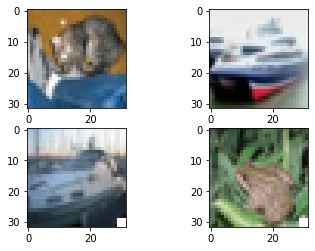

In [3]:
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(x[0])
axarr[0,1].imshow(x[1])
axarr[1,0].imshow(x_bd[2])
axarr[1,1].imshow(x_bd[3])

## Step 2: Visualization

### 2.1: Frequency map

In [4]:
# Load model
model = generate_cls_model(args.model, args.num_classes)
model.load_state_dict(result["model"])
model.to(args.device)

criterion = nn.CrossEntropyLoss()
tran = get_transform(
    args.dataset, *([args.input_height, args.input_width]), train=False
)

print('Plotting frequency saliency map')
if args.model == "preactresnet18":
    target_layers = [model.layer4]
if args.model == "vgg19":
    target_layers = [model.features]
if args.model == "resnet18":
    target_layers = [model.layer4]
if args.model == "densenet161":
    target_layers = [model.features]
if args.model == "mobilenet_v3_large":
    target_layers = [model.features]
if args.model == "efficientnet_b3":
    target_layers = [model.features]

model.eval()

Plotting frequency saliency map


PreActResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (layer1): Sequential(
    (0): PreActBlock(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): PreActBlock(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
  )
  (layer2): Sequential(
    (0): PreActBlock(
      (bn1): BatchNorm2d

In [5]:
# select visualization the index of images
x_bd_ori_idx = result_attack['bd_test']['original_index']
index = random.sample(np.arange(len(x_bd)).tolist(), 2)
index_ori = [x_bd_ori_idx[i] for i in index]

x_benign_select = []
y_benign_select = []
x_bd_select = []
y_bd_select = []
for id in index_ori:
    x_benign_select.append(np.array(x[id]))
    y_benign_select.append(np.array(y[id]))
for id in index:
    x_bd_select.append(np.array(x_bd[id]))
    y_bd_select.append(np.array(y_bd[id]))

if args.result_file_defense!='None':
    result = load_attack_result(save_path + "/defense_result.pt")
else:
    result = result_attack

In [6]:
# load visualization data
x_v = np.concatenate((x_benign_select,x_bd_select), axis=0)
y_v = np.concatenate((y_benign_select,y_bd_select), axis=0)
data_set = list(zip(x_v, y_v))
data_set_o = prepro_cls_DatasetBD(
    full_dataset_without_transform=data_set,
    poison_idx=np.zeros(
        len(data_set)
    ),  # no further poison steps for visualization data
    bd_image_pre_transform=None,
    bd_label_pre_transform=None,
    ori_image_transform_in_loading=tran,
    ori_label_transform_in_loading=None,
    add_details_in_preprocess=False,
)
data_loader = torch.utils.data.DataLoader(
    data_set_o, batch_size=args.batch_size, num_workers=args.num_workers, shuffle=False
)

for trans_t in data_loader.dataset.ori_image_transform_in_loading.transforms:
    if isinstance(trans_t, transforms.Normalize):
        denormalizer = get_dataset_denormalization(trans_t)
class_names = np.array(args.class_names).reshape([-1])
test_label = np.concatenate([y_v[:2], y_v[:2]])

pre-process bd dataset: 100%|██████████| 4/4 [00:00<00:00, 16116.44it/s]


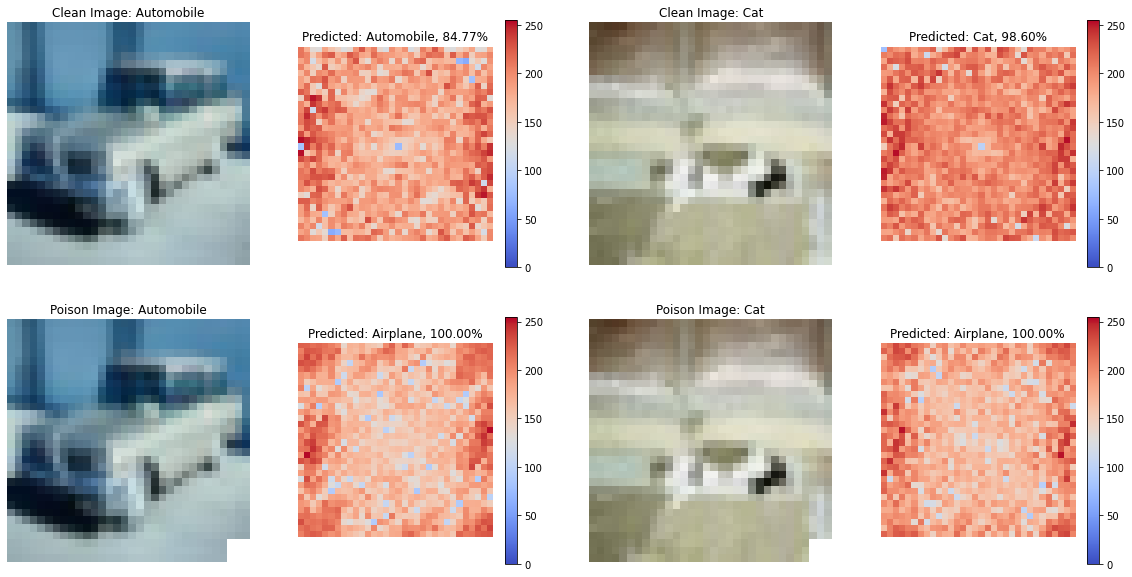

In [7]:
# Frequency saliency map 
full_image = []
full_target = []
for batch_idx, (inputs, targets) in enumerate(data_loader):
    full_image.append(inputs)
    full_target.append(targets)
full_image_t = torch.cat(full_image, 0)
full_target_t = torch.cat(full_target, 0)
test_images = torch.cat([full_image_t[:2], full_image_t[-2:]]).to(args.device)
sfm = nn.Softmax(dim=1)
outputs = model(test_images)
pre_p, pre_label = torch.max(sfm(outputs), dim=1)


frequency_maps = []
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
vnorm = mlp.colors.Normalize(vmin=0, vmax=255)
for im in range(4):
    rgb_image = np.swapaxes(
        np.swapaxes(denormalizer(test_images[im]).cpu().numpy(), 0, 1), 1, 2
    )
    frequency_map = saliency(test_images[im], model)
    rgb_image[rgb_image < 1e-12] = 1e-12
    axes[im // 2, im % 2 * 2].imshow(rgb_image)
    axes[im // 2, im % 2 * 2].axis("off")
    if im == 0 or im ==1:
        axes[im // 2, im % 2 * 2].set_title(
            "Clean Image: %s" % (class_names[test_label[im]].capitalize())
        )
    else:
        axes[im // 2, im % 2 * 2].set_title(
            "Poison Image: %s" % (class_names[test_label[im]].capitalize())
        )
    image = axes[im // 2, im % 2 * 2 + 1].imshow(frequency_map, cmap=plt.cm.coolwarm, norm=vnorm)
    plt.colorbar(image, ax=axes[im // 2, im % 2 * 2 + 1], orientation='vertical')
    axes[im // 2, im % 2 * 2 + 1].axis("off")
    axes[im // 2, im % 2 * 2 + 1].set_title(
        "Predicted: %s, %.2f%%" % (class_names[pre_label[im]].capitalize(), pre_p[im] * 100)
    )
plt.savefig(args.save_path + "/frequency_map.png")